In [1]:
# EDA 과정에 대해서 시행해볼 것임.
# 먼저 필요한 라이브러리를 불러오기

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#데이터 불러오기 
PATH = '../data/'

train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_quality  = pd.read_csv(PATH+'train_quality_data.csv')
train_problem  = pd.read_csv(PATH+'train_problem_data.csv')

test_err  = pd.read_csv(PATH+'test_err_data.csv')
test_quality  = pd.read_csv(PATH+'test_quality_data.csv')

In [3]:
# err
print("err data size")
print(f"train_err shape : {train_err.shape}")
print(f"test_err shpae : {test_err.shape}")

# quality
print("quality data size")
print(f"train_quality shape : {train_quality.shape}")
print(f"test_quality shape : {test_quality.shape}")

err data size
train_err shape : (16554663, 6)
test_err shpae : (16532648, 6)
quality data size
train_quality shape : (828624, 16)
test_quality shape : (747972, 16)


In [4]:
# error data head
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [5]:
# quality data head
train_quality.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


In [17]:
print('train_quality 의 에러데이터')
train_quality.isna().sum()

train_quality 의 에러데이터


time               0
user_id            0
fwver          40080
quality_0     144432
quality_1          0
quality_2      40113
quality_3          0
quality_4          0
quality_5         20
quality_6          0
quality_7          0
quality_8          0
quality_9          0
quality_10         0
quality_11         0
quality_12         0
fwver_str          0
dtype: int64

In [7]:
print('train_err 의 에러데이터')
train_err.isna().sum()

train_err 의 에러데이터


user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
dtype: int64

In [8]:
# quality 데이터에서 qualoty_2가 -1인 행을 찾고 이들의 합을 구하기
# quality_2가 -1 이면 quality_0 이 -1 임을 알 수 있다.
train_quality[train_quality['quality_2'] == -1].describe()

,time,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_6,quality_11,quality_12
count,1.443920e+05,144392.000000,130828.0,144392.000000,144392.0,144392.0,144392.0,144392.000000,144392.000000,144392.000000
mean,2.020112e+13,17677.837740,-1.0,-0.999993,-1.0,0.0,0.0,-0.999993,-0.999993,0.053659
std,8.811552e+06,4401.763827,0.0,0.002632,0.0,0.0,0.0,0.002632,0.002632,0.345903
min,2.020103e+13,10002.000000,-1.0,-1.000000,-1.0,0.0,0.0,-1.000000,-1.000000,0.000000
25%,2.020111e+13,13930.000000,-1.0,-1.000000,-1.0,0.0,0.0,-1.000000,-1.000000,0.000000
50%,2.020112e+13,17568.000000,-1.0,-1.000000,-1.0,0.0,0.0,-1.000000,-1.000000,0.000000
75%,2.020112e+13,21691.000000,-1.0,-1.000000,-1.0,0.0,0.0,-1.000000,-1.000000,0.000000
max,2.020113e+13,24997.000000,-1.0,0.000000,-1.0,0.0,0.0,0.000000,0.000000,13.000000


In [25]:
train_quality.corr()

,time,user_id,quality_0,quality_1,quality_2,quality_6,quality_11,quality_12,fwver_str
time,1.000000,-0.001218,-0.003262,0.001618,-0.002101,-0.012737,0.000724,0.026708,0.024921
user_id,-0.001218,1.000000,0.006651,-0.002403,0.003458,-0.017612,-0.007521,0.019467,0.009919
quality_0,-0.003262,0.006651,1.000000,0.004306,0.999535,-0.000135,0.006627,0.009599,0.013230
quality_1,0.001618,-0.002403,0.004306,1.000000,0.002976,0.028869,0.562785,0.002337,-0.026419
quality_2,-0.002101,0.003458,0.999535,0.002976,1.000000,0.001121,0.006914,0.004986,0.006664
quality_6,-0.012737,-0.017612,-0.000135,0.028869,0.001121,1.000000,0.043297,-0.006372,0.019045
quality_11,0.000724,-0.007521,0.006627,0.562785,0.006914,0.043297,1.000000,0.056308,-0.054061
quality_12,0.026708,0.019467,0.009599,0.002337,0.004986,-0.006372,0.056308,1.000000,-0.157139
fwver_str,0.024921,0.009919,0.013230,-0.026419,0.006664,0.019045,-0.054061,-0.157139,1.000000


<AxesSubplot:>

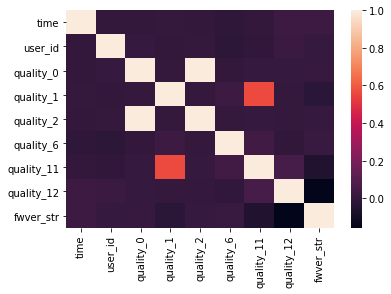

In [24]:
sns.heatmap(train_quality.corr())

In [23]:
# quality 3, 4 는 전부 0 이기 때문에 그냥 드랍하면 된다.
train_quality[train_quality['quality_3'] != 0].count()
train_quality[train_quality['quality_4'] != 0].count()

# 드랍코드
train_quality=train_quality.drop(columns=['quality_3','quality_4'])

# 0과 2 는 연관성이 굉장히 높음, 11과 1도 높은 편

# 2를 드랍하는 코드 / 2가 없는 경우는 펌웨어 버전이 나타나지 않는 경우임
#rain_quality.drop(['quality_2'])

In [13]:
# 펌웨어 버전에 대한 라벨 처리
from sklearn.preprocessing import LabelEncoder
train_quality.dtypes
encoder = LabelEncoder()

In [14]:
# 펌웨어 버전에 대해 str 자료형으로 변환
train_quality['fwver_str'] = train_quality['fwver'].astype('|S')

In [15]:
# 인코딩 작업수행
encoder.fit(train_quality['fwver_str'])
train_quality['fwver_str'] = encoder.transform(train_quality['fwver_str'])

In [26]:
train_quality['fwver'].isna().sum()

40080

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,fwver_str
38316,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
38317,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
38318,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
38319,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
38320,20201120010000,10693,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
828332,20201109232000,24982,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,27
828333,20201109232000,24982,NaN,NaN,-1,NaN,-1,-1,0,0,0,0,-1,0,27
828334,20201109232000,24982,NaN,NaN,-1,NaN,-1,-1,0,0,0,0,-1,0,27
